In [125]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

In [126]:
#define symbols
#finger pulley and motor pulley radii, joint angles
R_p, R_m, th1, th2 = sym.symbols(r'R_p, R_m, \theta_1, \theta_2')

#link lengths, stall torque (before gearing), gear ratio
L1, L2, ts, G = sym.symbols(r'L_1, L_2, \tau_s, G')

#actual values from CAD model and motor data; not configuration dependent
subslist = [(L1, 38e-3), (L2, 35e-3), (ts, 0.04), (R_m, 9.5e-3), (R_p, 8.58e-3), (G, 22.6)] #units in N and m

## Structure matrix and transmission jacobian

#### Definitions:
Let...
- $\mathbf{A}$ be the structure matrix
- $f$ be the vector of tension forces in the tendons, 
- $\theta$ be the joint angle vector,
- $\tau$ be the joint torque vector, 
- $v$ be the tendon linear velocity vector, 
- $\phi$ be the motor angle vector


By definition:
$\mathbf{\tau} = \mathbf{Af}$

and note relation between force and motor torque:

$Rf = \tau_m$  

$f=R^{-1}\tau_m$

relation between tendon speed and motor angular speed:

$v = R\dot{\phi}$

Now apply conservation of power:

$
\dot{\theta}^T\tau = v^Tf
$

$
\dot{\theta}^T\mathbf{Af} = v^Tf
$

$
\dot{\theta}^T\mathbf{A} = v^T
$

Note the relation between the linear speeds of the tendons and motor angular velocity:
$
v=R\dot{\phi}
$

To get the joint angle mapping, we can integrate but the constant of integration means the joint and motor
angles are relative to a reference point which we can get by using the hardstop.

$
\theta^T\mathbf{A} = \mathbf{R}\phi
$

$
\mathbf{A}^T\theta = \mathbf{R}\phi
$

$
\theta = {\mathbf{A}^T}^\dag \mathbf{R} \phi
$

Therefore, the transmission jacobian is computed: $\mathbf{T} =  {\mathbf{A}^T}^\dag \mathbf{R} $

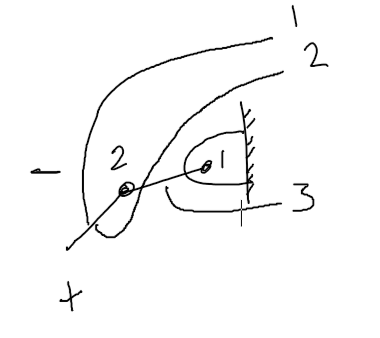

Assuming identical finger pulley radii on the routing diagram, we have the structure matrix A:

$\mathbf{A}=
\begin{bmatrix}
-R_p & -R_p & R_p \\
-R_p & R_p & 0 \\
\end{bmatrix}
$

The pseudoinverse of $\mathbf{A}^T$ is used to compute the transmission jacobian:

$
{\mathbf{A}^T}^\dag =
\begin{bmatrix}
-\frac{1}{3R_p} & -\frac{1}{3R_p} & \frac{1}{3R_p} \\
-\frac{1}{2R_p} & \frac{1}{2R_p} & 0 \\
\end{bmatrix}
$

**Note that the pinv() function in sympy doesn't give us the $A^\dag$ that we want

In [127]:
#structure matrix
A = sym.Matrix([[-R_p, -R_p, R_p],
                [-R_p, R_p, 0]])
 
Atpinv = sym.Matrix([[-1/(3*R_p), -1/(3*R_p), 1/(3*R_p)],
                    [-1/(2*R_p), 1/(2*R_p), 0]])

Apinv = Atpinv.T

# A = sym.Matrix([[R_p, R_p, -R_p],
#                 [0, R_p, -R_p]])

R = sym.eye(3) * R_m #motor shaft matrix

#transmission jacobian
T = Atpinv * R

In [128]:
#confirm the structure matrix and the inverse is correct
display(A)
display(Atpinv)
display(T)
#display(Atpinv * A.T)

Matrix([
[-R_p, -R_p, R_p],
[-R_p,  R_p,   0]])

Matrix([
[-1/(3*R_p), -1/(3*R_p), 1/(3*R_p)],
[-1/(2*R_p),  1/(2*R_p),         0]])

Matrix([
[-R_m/(3*R_p), -R_m/(3*R_p), R_m/(3*R_p)],
[-R_m/(2*R_p),  R_m/(2*R_p),           0]])

In [129]:
#transmission matrix motor angular speed -> joint angular speed
#note that when using encoders, we should account for the gear ratio, G = 22.6
T.subs(subslist) #radii in mm

Matrix([
[-0.369075369075369, -0.369075369075369, 0.369075369075369],
[-0.553613053613054,  0.553613053613054,                 0]])

## Mapping between motor and joint torque

Forward problem: given motor angle vector relative to the reference, we can compute the joint angles using the transmission matrix as mentioned above.

Inverse problem: given a desired joint configuration, we can drive the finger to the configuration by using a controller that maps the joint error to $\tau$ which we use to
do torque control until we reach position

Torques on the joints due to gravity, assuming the centroid of the link is located at $x_c$ from the corresponding
joint:

$
\tau_1 = m_1 x_{c,1} cos(\theta_1) + m_2(x_{c,1} cos(\theta_1) + x_{c,2}cos(\theta_1 + \theta_2))
$

$
\tau_2 =  m_2 x_{c,2} cos(\theta_1+\theta_2)
$


We can use the equation $\tau = Af$ to get the relation between motor and joint torques. This tells us the motor torques to exert in order to get the torques on the joints. We should also add the torque due to gravity, if applicable.

$\tau_j = AR^{-1} \tau_m$


$
\tau_m = R A^\dag \tau_j
$

Note that the antagonistic configuration of the tendons means that increasing motor torque does not necessarily mean that we increase joint torque. Consider the situation where we increase the tension in tendons 1 and 2 simultaneously, these will cancel out and provide no torque. This should not be an issue using the above equation as the solution will be unique. However, this example illustrates that going the other way, $\tau_m \rightarrow \tau_j$, cannot be done uniquely.


First, let the error be computed based off the joint positions estimated from the motor positions $\phi$. Then, design a controller using this error for joint torque control and use the mapping to get motor torques.

$
e = (\theta_d - \theta(\phi))
$ 

$
\tau_j = PID(e)
$

$
\tau_m = R A^\dag \tau_j
$

Note that we can hardcode the matrices, including the pseudoinverses, for speed since they are not dependent on joint configurations.

In [130]:
#matrix for mapping between joint->motor torque
J_jm = R * Apinv
npJ_jm = np.array(J_jm.subs(subslist))

In [131]:
max_torque = G*ts
max_force = max_torque.subs(subslist) / R_m.subs(subslist)
max_force

95.1578947368421

In [132]:
#motor to joint torques:
J_mj = A*R.inv()
J_mj.subs(subslist)

Matrix([
[-0.903157894736842, -0.903157894736842, 0.903157894736842],
[-0.903157894736842,  0.903157894736842,                 0]])

## Force/torque command offsetting

When assigning motor torque we need to worry about 1) negative forces in the tendons and 2) exceeding maximum force of the motor. 

To compute the tendon forces required for a joint torque, we first use:

$
f = A^\dag \tau_j
$

However, some entries of $f$ might be negative and so the requested force is not physically achievable because we can't compress a tendon.

Note that the solution of f to produce a joint torque is not unique; in fact, there is a null space in the structure matrix which means that certain combinations of forces will result in 0 torque (ex. for joint 2, if $f_1 = f_2$, we have $\tau_2 =0$). The physical interpretation of the null space is that it is the part of tendon force space that results in net 0 joint torques. Let us denote members of the null space as $f_o$.

$\tau_j=Af_{o}=0$

This means that adding an offset in the null space will not alter the joint torque produced. Due to the structure matrix, an offset on f1 and f2 will cancel on joint 2, but we will need to apply twice the offset on force 3 to cancel the offsets on f1 and f2. For this system, the null space is a line (ie. 1D subspace) and the offset must be in the form:

$
f_{o} = \alpha \begin{bmatrix}
1 \\
1 \\
2 \\
\end{bmatrix}
$

Where $\alpha$ is a scaling factor chosen to ensure that the minimum commanded force is at least some small positive number.

Then, we can convert this force to motor torque by using the matrix of motor pulley radii
$
\tau_m = R(f+f_{o})
$

Finally, check if any entries in $\tau_m$ exceed the maximum torque of the motor and scale the commanded motor torques so that $max(\tau_m) \le \tau_{max}$.

In [133]:
#Example for force adjustment procedure

#we want a joint torque of .1Nm for each joint
tj_test = np.array([.1, .1])

#np in front denotes numerical version of the variables
npRinv = np.array(R.inv().subs(subslist)) #pulley matrix
npA = np.array(A.subs(subslist)) #structure matrix

#calculate initial force
f_raw = npRinv @ npJ_jm @ tj_test
print('joint torque commands', tj_test)
print('raw force command', f_raw)

f_null = np.array([1, 1, 2])
scale = 0

#calculate the offset if needed
if(np.min(f_raw) < 0):
    min_ind = np.argmin(f_raw)
    scale = -np.min(f_raw) / f_null[min_ind]    
f_o = scale * f_null

#adjusted force
f_a = f_raw + f_o
print('forces after offset', f_a)
    
#check saturation of motor torque
f_max = 10 #example maximum force; if we calculate using motor stall torque, fmax = 100N

#scale if needed
sat_scale = 1
if(np.max(f_a) > f_max):
    max_ind = np.argmax(f_a)
    sat_scale = f_max / np.max(f_a)
    
f_out = sat_scale * f_a
print('commanded forces', f_out)
print('resulting joint torques', npA @ f_out)

joint torque commands [0.1 0.1]
raw force command [-9.71250971250971 1.94250194250194 3.88500388500389]
forces after offset [0 11.6550116550117 23.3100233100233]
commanded forces [0 5.00000000000000 10.0000000000000]
resulting joint torques [0.0429000000000000 0.0429000000000000]


## Velocity and force kinematics

We now have a way to compute the joint angles based on encoder information. This section will focus on using this information to find the fingertip position with forward kinematics and analyzing the static force that can be exerted by the fingertip. 

Reference: Modern Robotics (textbook from ME449)

Let:

$x_{ee}$ be the fingertip (end-effector) position in the base/world frame

$J_{ee}$ be the fingertip Jacobian representing sensitivity of the fingertip velocity to joint velocity

For the simple 2R robot finger, computing the fingertip position given the joint angles $\theta$ and the link lengths $L_1$ and $L_2$ yields the following:

$
\mathbf{x} =  
\begin{bmatrix}
L_1cos(\theta_1) + L_2cos(\theta_1 + \theta_2)\\
L_1sin(\theta_1) + L_2sin(\theta_1 + \theta_2)\\
\end{bmatrix} =h(\theta(t))
$

We can compute the Jacobian $J_{ee}$ which is defined:
$
\dot{x}_{ee} = J_{ee}(\theta)\dot{\theta}
$

$
\dot{x}_{ee} = \frac{\partial h}{\partial \theta} \frac{\partial \theta}{\partial t}
$

In our case:
$
J_{ee}=
\begin{bmatrix}
-L_1sin(\theta_1)- L_2sin(\theta_1 + \theta_2) & -L_2sin(\theta_1 + \theta_2)\\
L_1cos(\theta_1) + L_2cos(\theta_1 + \theta_2) & L_2cos(\theta_1 + \theta_2) \\
\end{bmatrix}
$


As defined above, the end effector jacobian shows the sensitivity of end effector velocity to joint velocity. Now, we want to relate joint torque to fingertip force. We can do so by power conservation:

Note that in this section, $f$ represents the fingertip force vector rather than tendon forces.

$
f^T\dot{x} = \tau^T \dot{\theta}
$

$
f^TJ\dot{\theta} = \tau^T \dot{\theta}
$

$
f^TJ = \tau^T
$

$\tau = J^Tf$

$f = {J^T}^\dag \tau$

We can now relate joint torques to the fingertip force. However, the joints are not driven directly by motors; instead, the wiring of the tendons means that there is coupling between the motor inputs and the corresponding tendon torques. So, before we can find the maximum force which can be exerted, we must find the feasible torque space.

I assume that each motor can output any torque between $\tau_m \in G[-\tau_s, \tau_s]$. In the 3D motor torque space, the feasible torques are a cube.


In [134]:
Jee = sym.Matrix([[-L1*sym.sin(th1) - L2*sym.sin(th1+th2), - L2*sym.sin(th1+th2)],
                  [L1*sym.cos(th1) + L2*sym.cos(th1+th2), L2*sym.cos(th1+th2)]])
Jee

Matrix([
[-L_1*sin(\theta_1) - L_2*sin(\theta_1 + \theta_2), -L_2*sin(\theta_1 + \theta_2)],
[ L_1*cos(\theta_1) + L_2*cos(\theta_1 + \theta_2),  L_2*cos(\theta_1 + \theta_2)]])

In [145]:
JeeT_pinv = Jee.T.pinv()
JeeT_pinv = sym.simplify(JeeT_pinv)
display(JeeT_pinv)

Matrix([
[cos(\theta_1 + \theta_2)/(L_1*sin(\theta_2)), -(L_1*cos(\theta_1) + L_2*cos(\theta_1 + \theta_2))/(L_1*L_2*sin(\theta_2))],
[sin(\theta_1 + \theta_2)/(L_1*sin(\theta_2)), -(L_1*sin(\theta_1) + L_2*sin(\theta_1 + \theta_2))/(L_1*L_2*sin(\theta_2))]])

In [144]:
#obtain an expression for maximization of the force vector


AttributeError: 'NoneType' object has no attribute 'simplify'

In [136]:
#sample motor torques to get feasible joint torques
n = 20
max_motor_output_torque = G * ts
max_motor_torque_val = float(max_motor_output_torque.subs(subslist))

tm = np.linspace(-max_motor_torque_val, max_motor_torque_val, n)

tau_j = np.empty((n**3, 2))

npJ_mj = np.array(J_mj.subs(subslist))

c = 0
for t1 in tm:
    for t2 in tm:
        for t3 in tm:
            tau_j[c] = npJ_mj @ np.array([t1,t2,t3])
            c+=1

Text(0, 0.5, 't2')

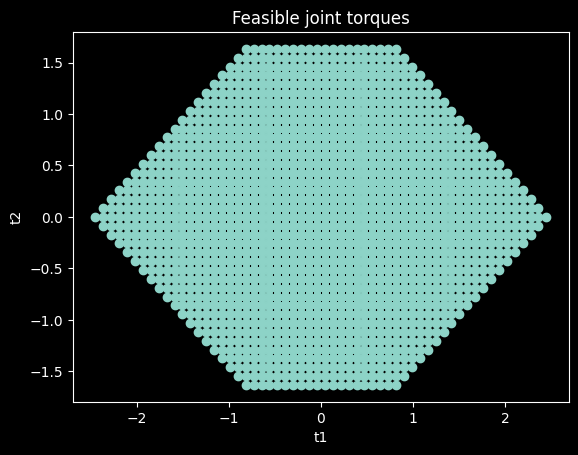

In [137]:
plt.scatter(tau_j[:,0], tau_j[:,1])
plt.title('Feasible joint torques')
plt.xlabel('t1')
plt.ylabel('t2')

In [138]:
#estimating the maximum fingertip force
tmx1 = 2*R_p*ts/R_m 
tmx2 = R_p*ts/R_m
Fmx0 = (tmx1 / (L1+L2) + tmx2 / L2) * G
Fmx0

G*(2*R_p*\tau_s/(R_m*(L_1 + L_2)) + R_p*\tau_s/(L_2*R_m))

In [139]:
feq = sym.Eq(Fmx0,Fmx0.subs(subslist))
print('absolute max torque in N at fingertip, fully extended (need to verify)')
display(feq)

absolute max torque in N at fingertip, fully extended (need to verify)


Eq(G*(2*R_p*\tau_s/(R_m*(L_1 + L_2)) + R_p*\tau_s/(L_2*R_m)), 45.6959011226697)

Note from luke about control following presentations on 2/14:

We must never allow the force in the tendon to be <0 because this is equivalent to pushing on a tendon and therefore introduces slack. The torque command may be negative (ie. letting the motor let go of some tendon length) but tension should be maintained in the tendons. This can be done by adding an offset if there is a request for negative force. For example, if the controller requests force [5, -3] on tendons 1 and 2, we should ensure non-negative force by adding an offset so we send force = [8, 0] to the motors. 